# COVID 19 Stats 

Data provided by Robert Koch Institut and processed by [NPGEO](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0).
Data License: Robert Koch-Institut (RKI), [dl-de/by-2-0](https://www.govdata.de/dl-de/by-2-0).

In [1]:
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

figsize=(25,17)
pd.options.display.max_rows = 1000

def prepare(col: str, refcol: str, df: pd.DataFrame) -> pd.Series:
    """Generate a series that can be use with the standar sum() function
    
    The documentation of the dataset specifies that "AnzahlFall" and other
    columns should not be simply summed up.
    """
    # Uses numpy's vectorize() for massive performance improvements.
    # Does the same thing as:
    # return pd.Series((row[col] if row[refcol] in [0,1] else 0) for _, row in df.iterrows())
    
    def preparation(col, refcol):
        return col if refcol == 0 or refcol == 1 else 0
    prep = np.vectorize(preparation)
    return pd.Series(prep(df[col].to_numpy(), df[refcol].to_numpy()))
    
def get_cases(date: datetime.date, url_prefix="https://raw.githubusercontent.com/woefe/covid19stats/autodata/data/silo") -> pd.DataFrame:
    date_str = date.isoformat()
    rki_cases = pd.read_csv(f"{url_prefix}/{date_str}.csv")
    rki_cases["Datenstand"] = pd.to_datetime(rki_cases["Datenstand"], format="%d.%m.%Y, %H:%M Uhr")
    rki_cases["Meldedatum"] = pd.to_datetime(rki_cases["Meldedatum"], format="%Y/%m/%d %H:%M:%S")
    rki_cases["Refdatum"] = pd.to_datetime(rki_cases["Refdatum"], format="%Y/%m/%d %H:%M:%S")
    rki_cases["cases"] = prepare("AnzahlFall", "NeuerFall", rki_cases)
    rki_cases["deaths"] = prepare("AnzahlTodesfall", "NeuerTodesfall", rki_cases)
    rki_cases["recovered"] = prepare("AnzahlGenesen", "NeuGenesen", rki_cases)
    return rki_cases

# Main data source
rki_cases = get_cases(datetime.date.today())

# Per district data
rki_lkr = pd.read_csv("data/RKI_Corona_Landkreise.csv")

Last update:

In [17]:
print(datetime.datetime.now().strftime("%c"))

Sun Nov  1 22:44:27 2020


## Overview

In [2]:
# Overview over entire data. Sanity check. Should be the same data as on the RKI dashboard
overall = rki_cases[["cases", "deaths", "recovered"]].sum(axis="rows")
print(f"          Overall cases: {overall.cases}")
print(f"         Overall deaths: {overall.deaths}")
print(f"Overall recovered cases: {overall.recovered}")
print(f" Currently active cases: {overall.cases - overall.deaths - overall.recovered}")
print(f"      Overall deathrate: {round(overall.deaths / overall.cases * 100, 3)}%")

          Overall cases: 532930
         Overall deaths: 10481
Overall recovered cases: 355935
 Currently active cases: 166514
      Overall deathrate: 1.967%


## Cases and deathrate by age (all of Germany, since January 2020)

In [3]:
by_age = rki_cases.groupby("Altersgruppe").sum()[["cases", "deaths", "recovered"]]
by_age["sick"] = by_age.cases - by_age.deaths - by_age.recovered
by_age["deathrate %"] = (by_age.deaths / by_age.cases) * 100
by_age

,cases,deaths,recovered,sick,deathrate %
Altersgruppe,,,,,
A00-A04,10115,1,6742,3372,0.009886
A05-A14,29219,2,18787,10430,0.006845
A15-A34,177489,22,120227,57240,0.012395
A35-A59,205742,496,141862,63384,0.241079
A60-A79,73880,3337,48584,21959,4.516784
A80+,35035,6622,19425,8988,18.901099
unbekannt,1450,1,308,1141,0.068966


## Cumulative cases since January 2020


In [4]:
#datecol = "Refdatum"
datecol = "Meldedatum"

#per_day = rki_cases[rki_cases["Bundesland"] == "Bayern"].copy()
per_day = rki_cases.copy()

per_day[datecol] = rki_cases[datecol].dt.floor("D")
per_day = per_day.groupby(datecol).sum()[["cases", "deaths", "recovered"]]
per_day.sort_values(datecol, inplace=True)
per_day["cum_cases"] = per_day["cases"].cumsum()
per_day["cum_deaths"] = per_day["deaths"].cumsum()
per_day["cum_recovered"] = per_day["recovered"].cumsum()

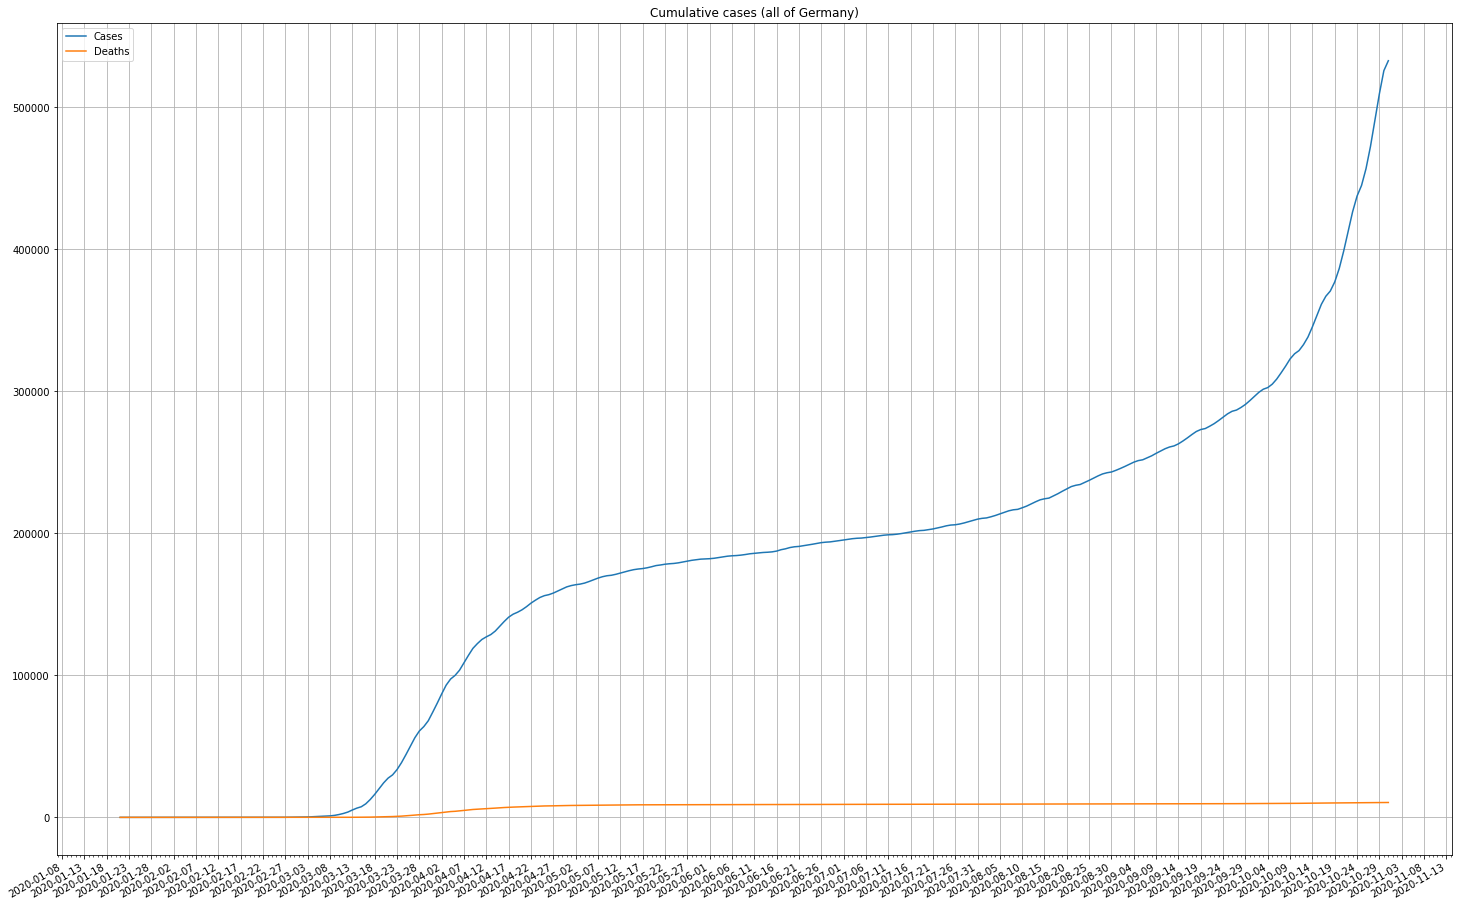

In [5]:
fig, ax = plt.subplots(figsize=figsize)
import matplotlib.dates as mdates

plt.plot(per_day.index, per_day.cum_cases, label="Cases")
plt.plot(per_day.index, per_day.cum_deaths, label="Deaths")

# The recovered cases should "lag behind" by approx., but it doesn't.
# That's because the dataset does not have a date indicating when a patient has recovered.
# Instead the original record seems to be updated.
# Hence, the I won't plot the recovered cases.
#plt.plot(per_day.index, per_day.cum_recovered, label="Recovered")
ax.get_xaxis().set_major_locator(mdates.DayLocator(interval=5))
ax.get_xaxis().set_minor_locator(mdates.DayLocator(interval=1))

fig.autofmt_xdate()
plt.legend()
plt.title("Cumulative cases (all of Germany)")
plt.grid()
plt.show()


## Daily registered cases per state

In [6]:
states = list(rki_cases.drop_duplicates("Bundesland").Bundesland)

colors = ["black", "gray", "lightgray", "red", "lightcoral", "goldenrod", "yellow", "olive", "chartreuse", "forestgreen", "aqua", "powderblue", "royalblue", "darkviolet", "violet", "fuchsia"]

#datecol = "Refdatum"
datecol = "Meldedatum"

def plot_data(state):
    df = rki_cases[rki_cases["Bundesland"] == state].copy()

    df[datecol] = rki_cases[datecol].dt.floor("D")
    df = df.groupby(datecol).sum()
    df.sort_values(datecol, inplace=True)
    return df


by_state = pd.DataFrame(index=rki_cases.groupby(datecol).first().index)
for state in states:
    by_state[state] = plot_data(state).cases
by_state = by_state.fillna(0) 

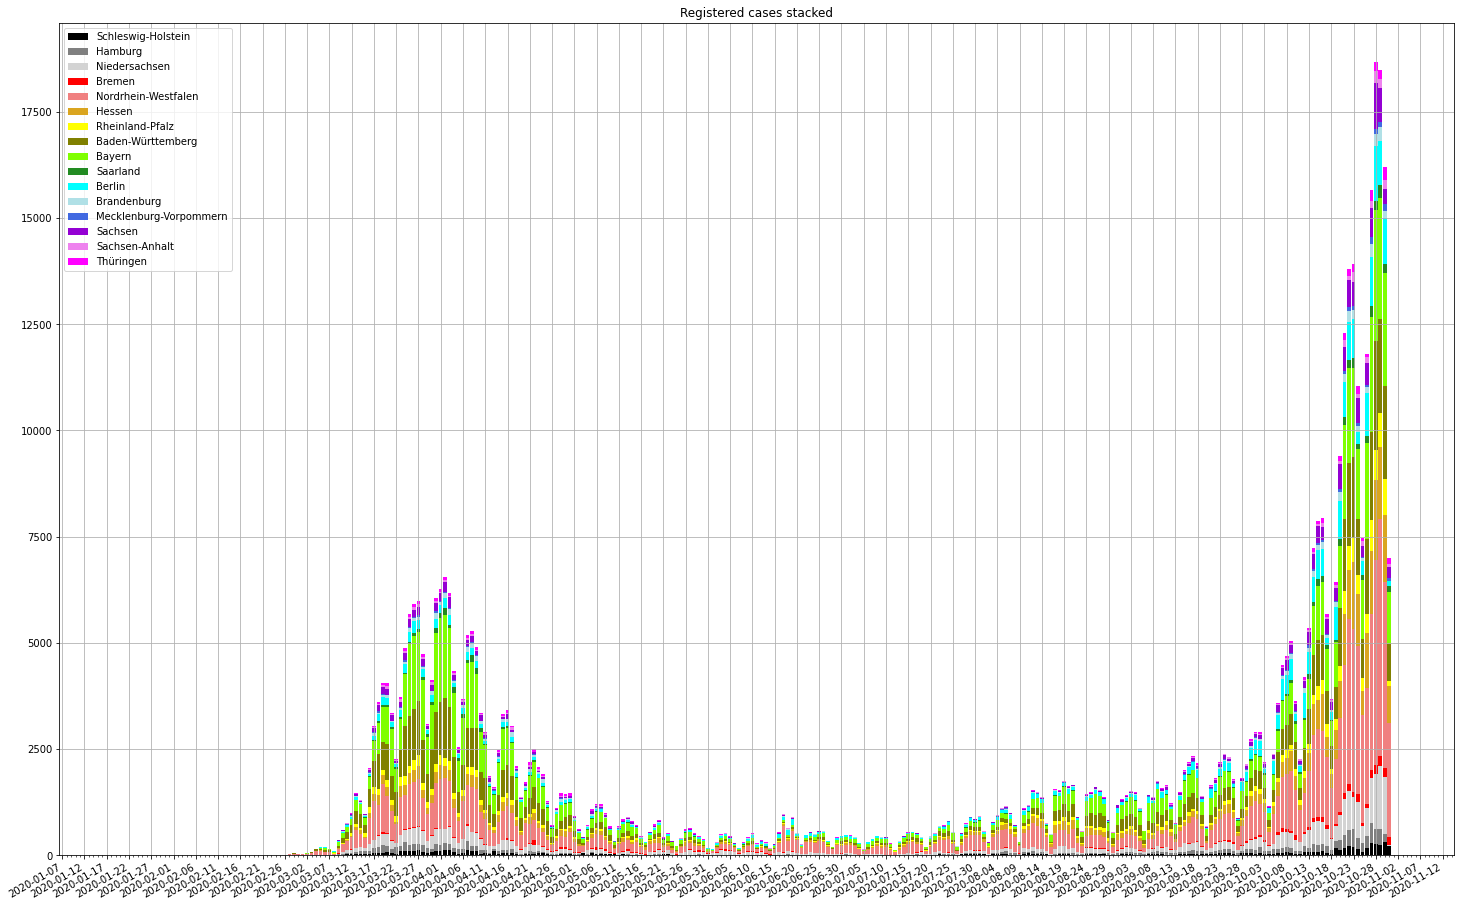

In [7]:
fig, ax = plt.subplots(figsize=figsize)

below = None
for state, color in zip(states, colors):
    df = by_state[state]
    if below is None:
        plt.bar(by_state.index, df, label=state, color=color)
        below = df
    else:
        plt.bar(by_state.index, df, label=state, color=color, bottom=below)
        below = below.add(df, fill_value=0)
        

ax.get_xaxis().set_major_locator(mdates.DayLocator(interval=5))
ax.get_xaxis().set_minor_locator(mdates.DayLocator(interval=1))

fig.autofmt_xdate()

plt.legend()
plt.title("Registered cases stacked")
plt.grid()
plt.show()

## Estimated active cases over time

In [8]:
import calendar
import os
import logging
from pathlib import Path
from multiprocessing import Pool
from typing import Tuple

SILO_DIR = Path("/tmp/data/silo")

def get_active_cases(date: datetime.date) -> Tuple[datetime.date,int]:
    date_str = date.isoformat()
    try:
        data_file = SILO_DIR / f"{date_str}.csv"
        rki_cases = pd.read_csv(data_file)
    except:
        #logging.warning("Ignoring file %s", data_file)
        return date, -1
    cases = prepare("AnzahlFall", "NeuerFall", rki_cases).sum()
    deaths = prepare("AnzahlTodesfall", "NeuerTodesfall", rki_cases).sum()
    recovered = prepare("AnzahlGenesen", "NeuGenesen", rki_cases).sum()
    return date, cases - deaths - recovered

cal = calendar.Calendar()
dates = (
    date 
    for month in range(4,11)
    for date in cal.itermonthdates(2020, month)
    if date <= datetime.date.today()
)

with Pool(len(os.sched_getaffinity(0))) as pool:
    cases_per_day = pool.map(get_active_cases, dates)

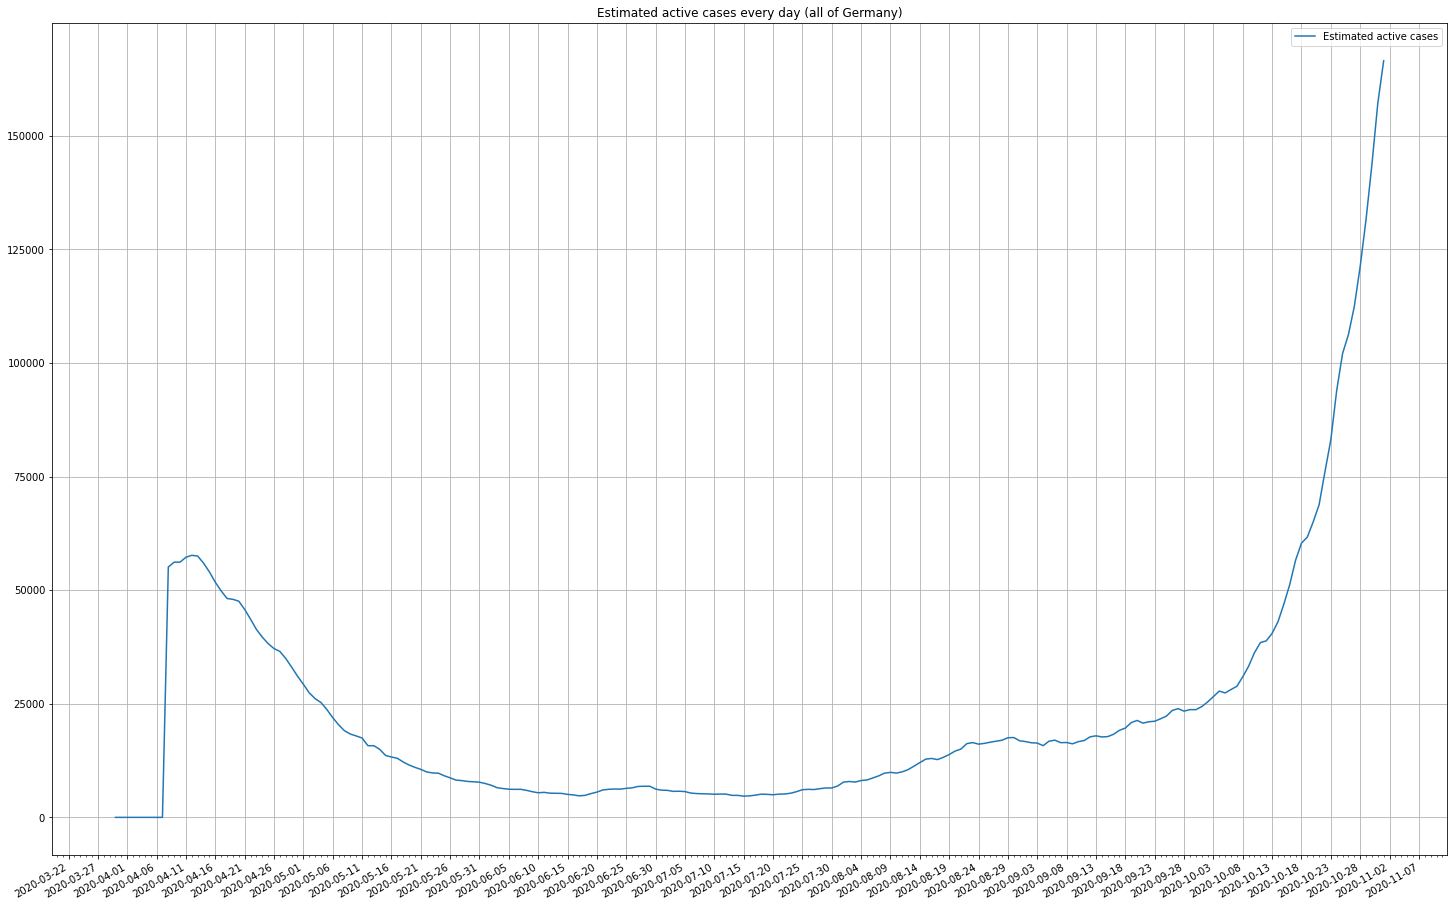

In [9]:
active_daily = pd.DataFrame(cases_per_day, columns=["date", "active_cases"]).sort_values("date")
fig, ax = plt.subplots(figsize=figsize)

plt.plot(active_daily.date, active_daily.active_cases, label="Estimated active cases")

ax.get_xaxis().set_major_locator(mdates.DayLocator(interval=5))
ax.get_xaxis().set_minor_locator(mdates.DayLocator(interval=1))

fig.autofmt_xdate()
plt.legend()
plt.title("Estimated active cases every day (all of Germany)")
plt.grid()
plt.show()

## Last seven days broken down by district

In [10]:
start_at = pd.to_datetime(datetime.date.today() - datetime.timedelta(days=7))
lkr = rki_lkr[["county", "EWZ", "KFL"]]
sum_lkr = rki_cases[rki_cases.Meldedatum >= start_at].groupby("Landkreis").sum()[["cases", "deaths", "recovered"]]
counties = pd.merge(lkr, sum_lkr, right_on="Landkreis", left_on="county")
counties["cases/100000 inhabitants"] = (counties["cases"]/counties["EWZ"])*100000
counties["cases/km²"] = counties["cases"]/counties["KFL"]
counties["cases/inhabitants"] = counties["cases"]/counties["EWZ"]
counties["deaths/km²"] = counties["deaths"]/counties["KFL"]
counties["deaths/inhabitants"] = counties["deaths"]/counties["EWZ"]
counties["inhabitants"] = counties["EWZ"]
counties.drop(["EWZ", "KFL"], axis="columns", inplace=True)
counties.sort_values(by="cases/100000 inhabitants", ascending=False)

## Cases, recovered, deaths (all of Germany)

,county,cases,deaths,recovered,cases/100000 inhabitants,cases/km²,cases/inhabitants,deaths/km²,deaths/inhabitants,inhabitants
133,LK Marburg-Biedenkopf,740,0,26,299.493290,0.586199,0.002995,0.000000,0.000000e+00,247084
254,LK Rottal-Inn,356,3,4,292.999292,0.277867,0.002930,0.002342,2.469095e-05,121502
410,SK Berlin Friedrichshain-Kreuzberg,746,1,59,264.483672,NaN,0.002645,NaN,3.545358e-06,282059
226,LK Berchtesgadener Land,278,1,22,262.439936,0.331008,0.002624,0.001191,9.440285e-06,105929
404,SK Berlin Neukölln,838,1,40,260.959196,NaN,0.002610,NaN,3.114072e-06,321123
64,SK Duisburg,1277,3,8,256.072960,5.485395,0.002561,0.012887,6.015810e-06,498686
108,SK Herne,392,0,1,250.560886,7.623493,0.002506,0.000000,0.000000e+00,156449
70,SK Remscheid,273,1,9,245.199303,3.663446,0.002452,0.013419,8.981659e-06,111338
224,SK Rosenheim,154,0,3,242.325062,4.137560,0.002423,0.000000,0.000000e+00,63551
118,SK Offenbach,303,0,15,232.575990,6.751337,0.002326,0.000000,0.000000e+00,130280
